# DATA 505 Final

## Goal: Can we predict what play the NFL coaches will run based on situations that happen before the play and how successful they are?

#### Import all the python packages we will be using

In [568]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from matplotlib.animation import FuncAnimation

## Part I: Retrieve the data

#### These csv's were retrieved from the nfl-data-py python package. We decided we wanted to look at the play-by-play data. Plays23 is every snap from the 2023-24 NFL football season, regular and postseason. Plays is every play from the 2021,2022, and 2023 seasons. 

In [569]:
plays = pd.read_csv("nfl_plays.csv")
plays23 = pd.read_csv("nfl_23_plays_offense_personnel.csv")

In [570]:
plays = plays[~plays['play_type'].isin(['kickoff', 'no_play','extra_point'])]
plays['running_clock'].unique()

array(['Stopped', 'Running'], dtype=object)

In [571]:
plays['running_clock'] = plays['running_clock'].map({'Running': 1, 'Stopped': 0})

In [572]:
plays['prev_play_type'].unique()

array([nan, 'kickoff', 'run', 'pass', 'punt', 'no_play', 'field_goal',
       'qb_spike', 'qb_kneel', 'extra_point'], dtype=object)

In [573]:
# Assuming df is your DataFrame and 'previous' is the column
plays['previous'] = plays['prev_play_type'].map({'no_play': 0, 
                                     'kickoff': 1,
                                     'field_goal': 2, 
                                     'pass': 3, 
                                     'punt': 4, 
                                     'qb_kneel': 5, 
                                     'qb_spike': 6, 
                                     'run': 7,
                                     'extra_point': 8})


## Part II: EDA

#### We wanted to see what the dataset looked like. Plays23 will look very similar

In [574]:
plays

,posteam,posteam_type,season,season_type,side_of_field,yardline_100,quarter_seconds_remaining,half_seconds_remaining,qtr,down,...,fumble_lost,touchdown,field_goal_attempt,punt_attempt,offense_formation,offense_personnel,route,running_clock,prev_play_type,previous
0,NaN,NaN,2021-22,REG,NaN,NaN,900.0,1800.0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2,TEN,home,2021-22,REG,TEN,75.0,900.0,1800.0,1,1.0,...,0.0,0.0,0.0,0.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",NaN,0,kickoff,1.0
3,TEN,home,2021-22,REG,TEN,78.0,863.0,1763.0,1,2.0,...,0.0,0.0,0.0,0.0,SHOTGUN,"1 RB, 2 TE, 2 WR",ANGLE,1,run,7.0
4,TEN,home,2021-22,REG,TEN,75.0,822.0,1722.0,1,3.0,...,0.0,0.0,0.0,0.0,SHOTGUN,"1 RB, 1 TE, 3 WR",HITCH,1,pass,3.0
5,TEN,home,2021-22,REG,TEN,75.0,819.0,1719.0,1,4.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,0,pass,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149017,KC,home,2023-24,POST,SF,32.0,127.0,127.0,5,3.0,...,0.0,0.0,0.0,0.0,SHOTGUN,"1 RB, 2 TE, 2 WR",NaN,1,pass,3.0
149018,KC,home,2023-24,POST,SF,13.0,86.0,86.0,5,1.0,...,0.0,0.0,0.0,0.0,SHOTGUN,"1 RB, 3 TE, 1 WR",NaN,1,run,7.0
149019,KC,home,2023-24,POST,SF,10.0,50.0,50.0,5,2.0,...,0.0,0.0,0.0,0.0,SHOTGUN,"1 RB, 1 TE, 3 WR",SCREEN,1,run,7.0
149020,KC,home,2023-24,POST,SF,3.0,6.0,6.0,5,1.0,...,0.0,1.0,0.0,0.0,SHOTGUN,"1 RB, 2 TE, 2 WR",FLAT,1,pass,3.0


In [575]:
plays.columns.tolist()

['posteam',
 'posteam_type',
 'season',
 'season_type',
 'side_of_field',
 'yardline_100',
 'quarter_seconds_remaining',
 'half_seconds_remaining',
 'qtr',
 'down',
 'time',
 'ydstogo',
 'play_type',
 'yards_gained',
 'pass_length',
 'pass_location',
 'run_location',
 'run_gap',
 'field_goal_result',
 'kick_distance',
 'posteam_timeouts_remaining',
 'defteam_timeouts_remaining',
 'posteam_score',
 'defteam_score',
 'score_differential',
 'interception',
 'safety',
 'fumble_lost',
 'touchdown',
 'field_goal_attempt',
 'punt_attempt',
 'offense_formation',
 'offense_personnel',
 'route',
 'running_clock',
 'prev_play_type',
 'previous']

#### We want to look at the distribution of play types count, based on situations, in our dataset.

<AxesSubplot:xlabel='count', ylabel='play_type'>

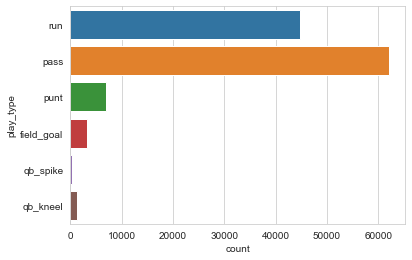

In [576]:
sns.countplot(data = plays, y = 'play_type')

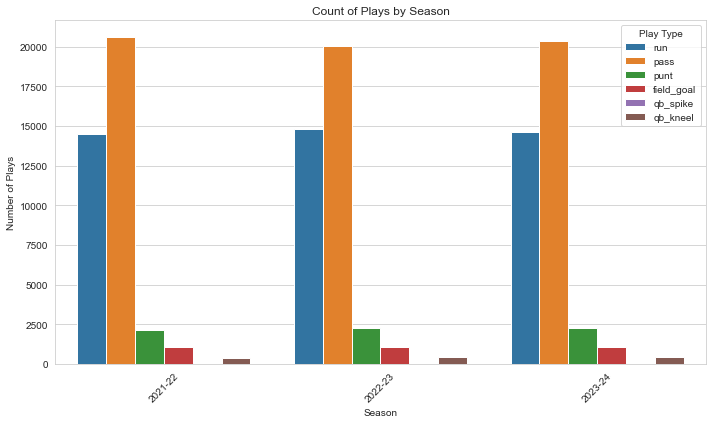

In [612]:
plt.figure(figsize=(10, 6))
sns.countplot(data=plays, x='season', hue='play_type')
plt.title('Count of Plays by Season')
plt.xlabel('Season')
plt.ylabel('Number of Plays')
plt.xticks(rotation=45)
plt.legend(title='Play Type')
plt.tight_layout()

plt.savefig('season.png') 
plt.show()

<AxesSubplot:xlabel='count', ylabel='play_type'>

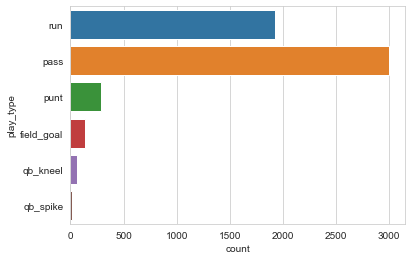

In [578]:
postseason = plays[plays['season_type'] == 'POST']

sns.countplot(data = postseason, y = 'play_type')

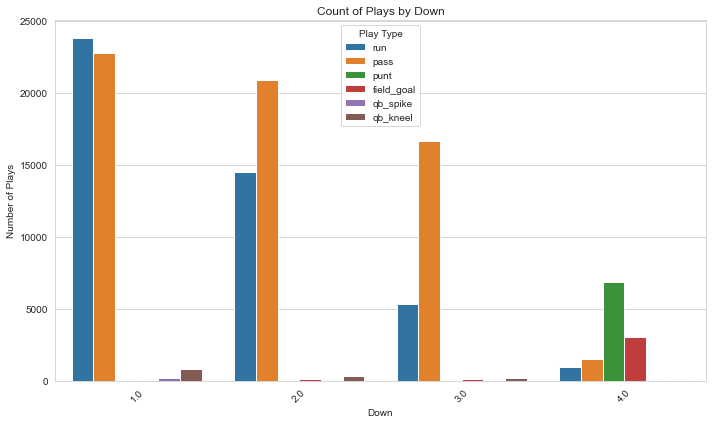

In [579]:
plt.figure(figsize=(10, 6))
sns.countplot(data=plays, x='down', hue='play_type')
plt.title('Count of Plays by Down')
plt.xlabel('Down')
plt.ylabel('Number of Plays')
plt.xticks(rotation=45)
plt.legend(title='Play Type')
plt.tight_layout()
plt.show()

## Part III: Decision Trees

#### Our goal is to classify these plays based on pre-snap situations. Since this is a classification problem let's try a decision tree first. 

#### We need to clean up the data a little for this to work

In [580]:
plays.dropna(subset=['down'], inplace=True)
plays.dropna(subset=['play_type'], inplace=True)
plays.dropna(subset=['score_differential'], inplace=True)
plays23.dropna(subset=['down'], inplace=True)
plays23.dropna(subset=['play_type'], inplace=True)
plays23.dropna(subset=['score_differential'], inplace=True)
plays23.dropna(subset=['defteam_score'], inplace=True)

#### Let's look at a smaller scale so we can visualize this. For this reason, we will just start with the 2023 data and a max depth of 2. We also will start with just the yard line the ball is on, the down, time left in the half, the quarter, and yards to go to get a first down.

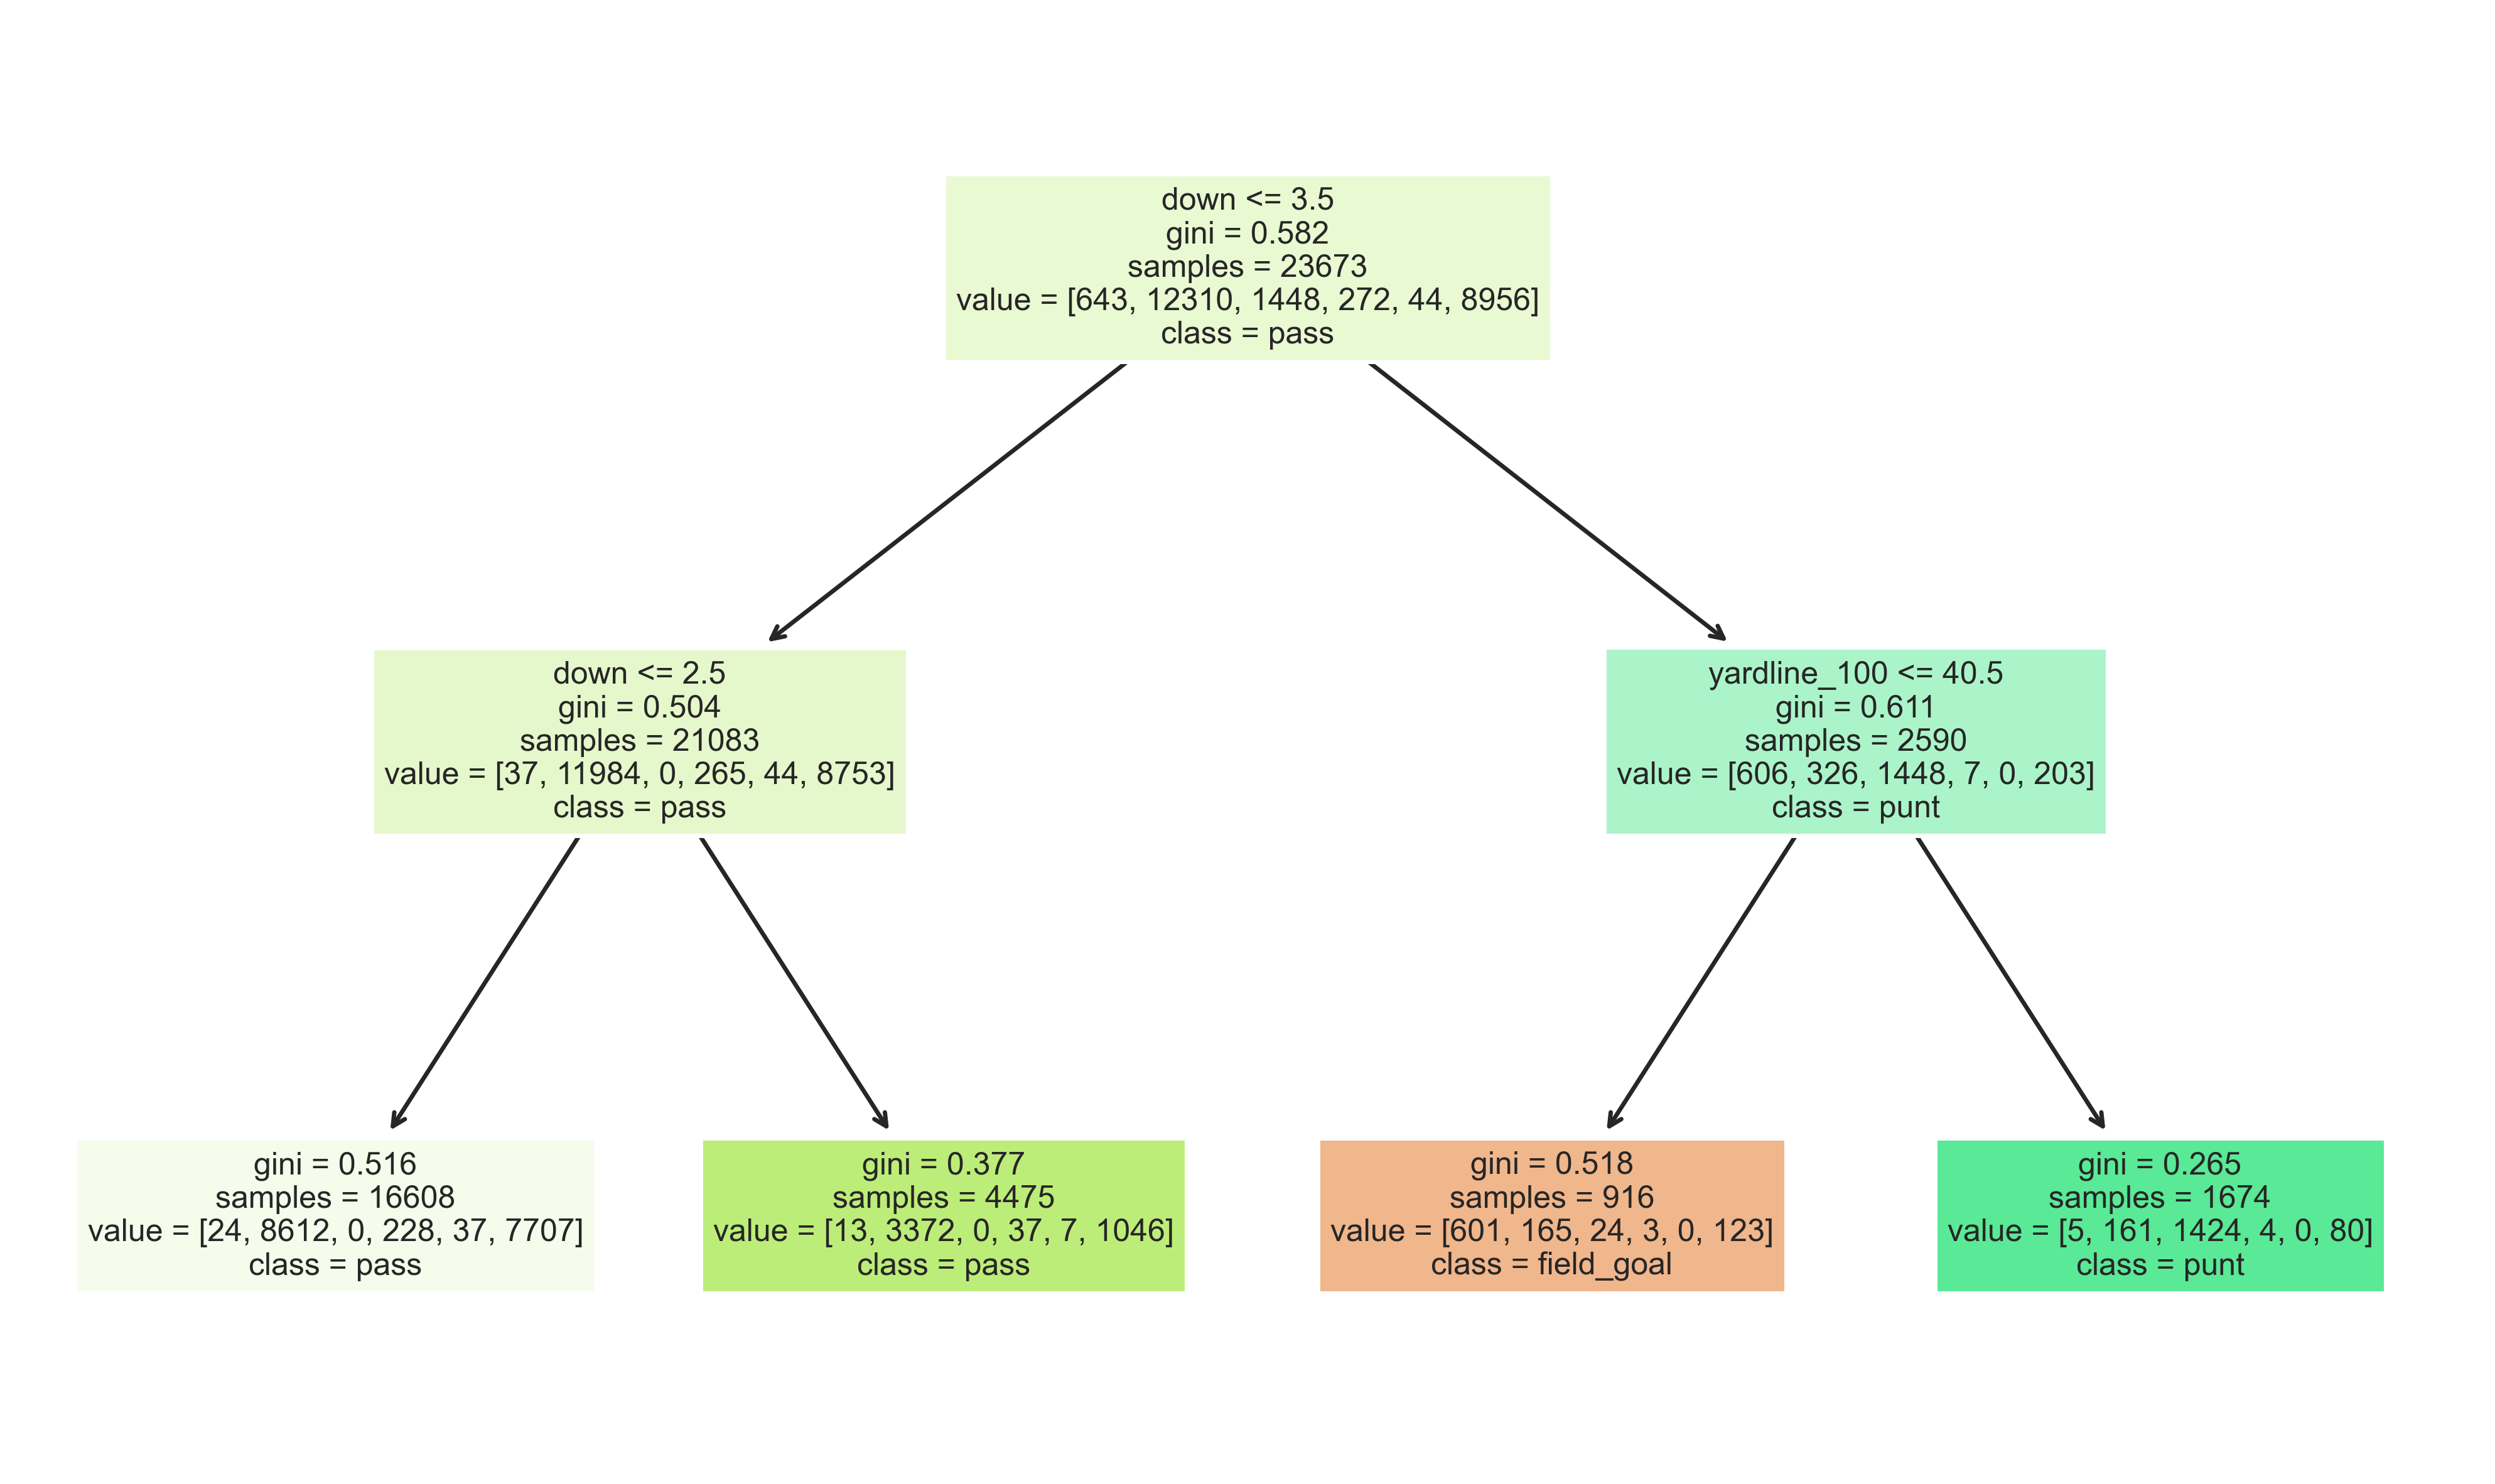

In [581]:
plays_predictors = plays23[['yardline_100', 
                        'down', 
                       'half_seconds_remaining', 
                        'qtr', 
                        'ydstogo']]
X = plays_predictors
y = plays23[['play_type']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create decision tree classifier
tree_clf_23 = DecisionTreeClassifier(max_depth=2, random_state=42)

# Train the classifier on the training data
tree_clf_23.fit(X_train, y_train)

# Plot decision tree
plt.figure(figsize=(10, 6), dpi=500)  # Adjust the figure size and DPI
plot_tree(tree_clf_23, filled=True, feature_names=X.columns, class_names=tree_clf_23.classes_)
plt.show()

#### Let run this with the larger dataset and a larger max_depth

In [582]:
data_predictors = plays[['yardline_100', 
                        'down', 
                       'half_seconds_remaining', 
                        'qtr', 
                        'ydstogo',
                        'score_differential',
                        'posteam_timeouts_remaining',
                        'defteam_timeouts_remaining']]
X = data_predictors
y = plays[['play_type']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create decision tree classifier
tree_clf = DecisionTreeClassifier(max_depth=45, random_state=42)

# Train the classifier on the training data
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=45, random_state=42)

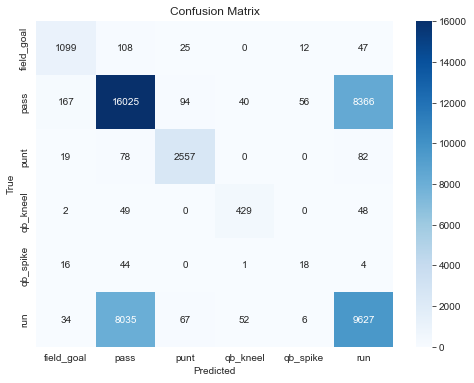

In [583]:
y_pred = tree_clf.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=tree_clf.classes_, yticklabels=tree_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [584]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  field_goal       0.82      0.85      0.84      1291
        pass       0.66      0.65      0.65     24748
        punt       0.93      0.93      0.93      2736
    qb_kneel       0.82      0.81      0.82       528
    qb_spike       0.20      0.22      0.21        83
         run       0.53      0.54      0.53     17821

    accuracy                           0.63     47207
   macro avg       0.66      0.67      0.66     47207
weighted avg       0.63      0.63      0.63     47207



In [585]:
importances = tree_clf.feature_importances_


feature_names = data_predictors.columns

# Print the feature importances
for i, importance in zip(feature_names, importances):
    print(f"Feature {i}: {importance}")

Feature yardline_100: 0.2209354227099105
Feature down: 0.15589754765646693
Feature half_seconds_remaining: 0.3045448846328211
Feature qtr: 0.04303676890884847
Feature ydstogo: 0.09044395043634237
Feature score_differential: 0.12851789073655212
Feature posteam_timeouts_remaining: 0.024682606816302244
Feature defteam_timeouts_remaining: 0.031940928102756234


In [586]:
true_positives = np.diag(conf_matrix)


total_instances = np.sum(conf_matrix, axis=1)

class_accuracy = true_positives / total_instances


overall_accuracy = np.sum(true_positives) / np.sum(conf_matrix)

class_names = ['field_goal', 'pass', 'punt', 'qb_kneel', 'qb_spike', 'run']
for i, acc in zip(class_names, class_accuracy):
    print(f'Class {i}: {acc*100:.2f}%\n')


print(f'Overall Accuracy: {overall_accuracy*100:.2f}%')

Class field_goal: 85.13%

Class pass: 64.75%

Class punt: 93.46%

Class qb_kneel: 81.25%

Class qb_spike: 21.69%

Class run: 54.02%

Overall Accuracy: 63.03%


#### Trying to add predictors of clocked stopped and previous play

In [587]:
plays.dropna(subset=['running_clock'], inplace=True)
plays.dropna(subset=['previous'], inplace=True)


In [588]:
data_predictors = plays[['yardline_100', 
                        'down', 
                       'half_seconds_remaining', 
                        'qtr', 
                        'ydstogo',
                        'score_differential',
                        'posteam_timeouts_remaining',
                        'defteam_timeouts_remaining',
                        'running_clock',
                        'previous'
                        ]]
X = data_predictors
y = plays[['play_type']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Create decision tree classifier
tree_clf = DecisionTreeClassifier(max_depth=45, random_state=42)

# Train the classifier on the training data
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=45, random_state=42)

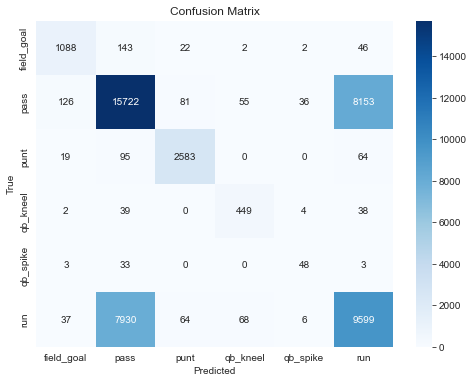

In [589]:

y_pred = tree_clf.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=tree_clf.classes_, yticklabels=tree_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [590]:
true_positives = np.diag(conf_matrix)


total_instances = np.sum(conf_matrix, axis=1)


class_accuracy = true_positives / total_instances


overall_accuracy = np.sum(true_positives) / np.sum(conf_matrix)

class_names = ['field_goal', 'pass', 'punt', 'qb_kneel', 'qb_spike', 'run']

for i, acc in zip(class_names, class_accuracy):
    print(f'Class {i}: {acc*100:.2f}%')


print(f'Overall Accuracy: {overall_accuracy*100:.2f}%')

Class field_goal: 83.50%
Class pass: 65.04%
Class punt: 93.55%
Class qb_kneel: 84.40%
Class qb_spike: 55.17%
Class run: 54.22%
Overall Accuracy: 63.34%


In [591]:
importances = tree_clf.feature_importances_


feature_names = data_predictors.columns

# Print the feature importances
for i, importance in zip(feature_names, importances):
    print(f"Feature {i}: {importance}")

Feature yardline_100: 0.21257117081027482
Feature down: 0.15099039595400413
Feature half_seconds_remaining: 0.2870395871300138
Feature qtr: 0.04149086385832513
Feature ydstogo: 0.09029548898816382
Feature score_differential: 0.12095119122367314
Feature posteam_timeouts_remaining: 0.023243039184226263
Feature defteam_timeouts_remaining: 0.03133416281712551
Feature running_clock: 0.012283932068259219
Feature previous: 0.029800167965934182




#### We wanted to see how this model would work for each team

In [592]:
teams = np.unique(plays['posteam'])

print(teams)
predictors = ['yardline_100', 
                            'down', 
                            'half_seconds_remaining', 
                            'qtr', 
                            'ydstogo',
                            'score_differential',
                            'posteam_timeouts_remaining',
                            'defteam_timeouts_remaining',
                            'running_clock',
                            'previous']

['ARI' 'ATL' 'BAL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DET' 'GB'
 'HOU' 'IND' 'JAX' 'KC' 'LA' 'LAC' 'LV' 'MIA' 'MIN' 'NE' 'NO' 'NYG' 'NYJ'
 'PHI' 'PIT' 'SEA' 'SF' 'TB' 'TEN' 'WAS']


#### This function takes in the team and what predictors we want to use to predict the plays off of

In [593]:
def plays_by_team(team, predictors):
    #Get Team Data
    team_data = plays[plays['posteam'] == team]
    #X is the predictors we passed in and y is what we want to predict
    X_team = team_data[predictors]
    y_team = team_data[['play_type']]

    #Want to create a 40/60 train test split
    X_train_team, X_test_team, y_train_team, y_test_team = train_test_split(X_team, y_team, test_size=0.4, random_state=42)

    #make the tree
    tree_clf_team = DecisionTreeClassifier(max_depth=45, random_state=42)

    #train the tree
    tree_clf_team.fit(X_train_team, y_train_team)
    
    #test our tree
    y_pred_team = tree_clf_team.predict(X_test_team)

    #create a confusion matrix with our test data
    conf_matrix_team = confusion_matrix(y_test_team, y_pred_team)
    
    
    #plt.figure(figsize=(8, 6))
    #sns.heatmap(conf_matrix_team, annot=True, fmt="d", cmap="Blues", xticklabels=tree_clf_team.classes_, yticklabels=tree_clf_team.classes_)
    #plt.xlabel('Predicted')
    #plt.ylabel('True')
    #plt.title(f'Confusion Matrix for {team}')
    
    
    true_positives = np.diag(conf_matrix_team)


    total_instances = np.sum(conf_matrix_team, axis=1)


    class_accuracy = true_positives / total_instances


    overall_accuracy = np.sum(true_positives) / np.sum(conf_matrix_team)

    class_names = tree_clf_team.classes_
    
    accuracy_data = f'Accuracy Data for: {team}\n'
    for i, acc in zip(class_names, class_accuracy):
        accuracy_data += f'Class {i}: {acc*100:.2f}%\n'
        
    Overall = f'Overall Accuracy: {overall_accuracy*100:.2f}%\n'
    
    report = classification_report(y_test, y_pred)


    return conf_matrix_team, accuracy_data, Overall, report, class_names

#### This will give the predictions based off of the team and predictors

In [594]:
team_results = {}
for i in teams:
    conf_matrix_team, accuracy_data_team, overall_team, report, class_names = plays_by_team(i, predictors)
    team_results[i] = {
        'conf_matrix': conf_matrix_team,
        'accuracy_data': accuracy_data_team,
        'overall': overall_team,
        'report': report,
        'class_names': class_names
    }

C:\Users\camdi\AppData\Local\Temp/ipykernel_66788/2087238207.py:37: RuntimeWarning: invalid value encountered in divide
  class_accuracy = true_positives / total_instances


Accuracy Data for: DEN
Class field_goal: 88.57%
Class pass: 59.94%
Class punt: 93.62%
Class qb_kneel: 35.29%
Class qb_spike: 0.00%
Class run: 55.58%

Overall Accuracy: 60.86%

              precision    recall  f1-score   support

  field_goal       0.85      0.83      0.84      1303
        pass       0.66      0.65      0.65     24173
        punt       0.94      0.94      0.94      2761
    qb_kneel       0.78      0.84      0.81       532
    qb_spike       0.50      0.55      0.52        87
         run       0.54      0.54      0.54     17704

    accuracy                           0.63     46560
   macro avg       0.71      0.73      0.72     46560
weighted avg       0.63      0.63      0.63     46560



Text(0.5, 1.0, 'Confusion Matrix for DEN')

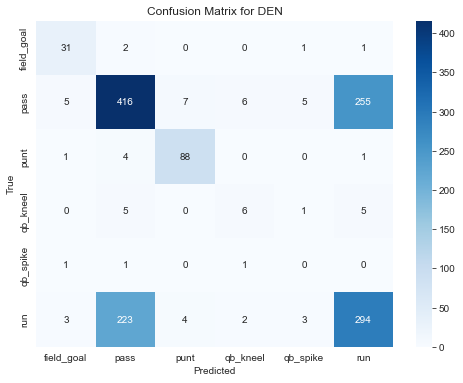

In [595]:
class_names = team_results[team_name]['class_names']
team_name = 'DEN'  
print(team_results[team_name]['accuracy_data'])
print(team_results[team_name]['overall'])
print(team_results[team_name]['report'])
plt.figure(figsize=(8, 6))
sns.heatmap(team_results[team_name]['conf_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {team_name}')

#### What is the overall accuracy for each team

In [596]:
for i in teams:
    print(i + ' ' +team_results[i]['overall'])

ARI Overall Accuracy: 60.56%

ATL Overall Accuracy: 63.60%

BAL Overall Accuracy: 61.32%

BUF Overall Accuracy: 60.96%

CAR Overall Accuracy: 63.47%

CHI Overall Accuracy: 57.47%

CIN Overall Accuracy: 62.56%

CLE Overall Accuracy: 62.33%

DAL Overall Accuracy: 63.02%

DEN Overall Accuracy: 60.86%

DET Overall Accuracy: 59.43%

GB Overall Accuracy: 60.28%

HOU Overall Accuracy: 62.22%

IND Overall Accuracy: 64.77%

JAX Overall Accuracy: 63.35%

KC Overall Accuracy: 64.28%

LA Overall Accuracy: 62.22%

LAC Overall Accuracy: 63.16%

LV Overall Accuracy: 66.04%

MIA Overall Accuracy: 64.48%

MIN Overall Accuracy: 63.43%

NE Overall Accuracy: 60.82%

NO Overall Accuracy: 66.45%

NYG Overall Accuracy: 60.10%

NYJ Overall Accuracy: 65.13%

PHI Overall Accuracy: 60.82%

PIT Overall Accuracy: 62.94%

SEA Overall Accuracy: 62.42%

SF Overall Accuracy: 63.47%

TB Overall Accuracy: 65.46%

TEN Overall Accuracy: 62.32%

WAS Overall Accuracy: 59.96%



## Part IV: Random Forest

In [597]:
data_predictors = plays[['yardline_100', 
                        'down', 
                       'half_seconds_remaining', 
                        'qtr', 
                        'ydstogo',
                        'score_differential',
                        'posteam_timeouts_remaining',
                        'defteam_timeouts_remaining',
                        'running_clock',
                        'previous']]
X = data_predictors
y = plays[['play_type']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

C:\Users\camdi\AppData\Local\Temp/ipykernel_66788/3964765456.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

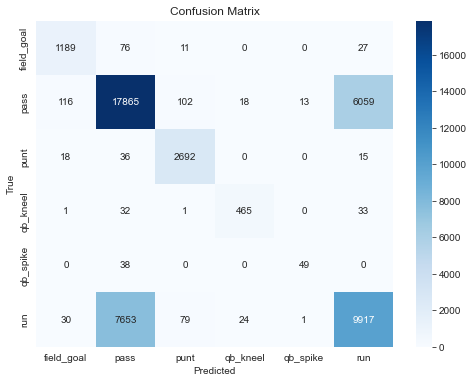

In [598]:
y_pred = rf_classifier.predict(X_test)


conf_matrix = confusion_matrix(y_test, y_pred)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=rf_classifier.classes_, yticklabels=rf_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [599]:
true_positives = np.diag(conf_matrix)


total_instances = np.sum(conf_matrix, axis=1)

class_accuracy = true_positives / total_instances


overall_accuracy = np.sum(true_positives) / np.sum(conf_matrix)


class_names = ['field_goal', 'pass', 'punt', 'qb_kneel', 'qb_spike', 'run']
for i, acc in zip(class_names, class_accuracy):
    print(f'Class {i}: {acc*100:.2f}%\n')

print(f'Overall Accuracy: {overall_accuracy*100:.2f}%')

Class field_goal: 91.25%

Class pass: 73.90%

Class punt: 97.50%

Class qb_kneel: 87.41%

Class qb_spike: 56.32%

Class run: 56.02%

Overall Accuracy: 69.11%


In [600]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  field_goal       0.88      0.91      0.89      1303
        pass       0.70      0.74      0.72     24173
        punt       0.93      0.98      0.95      2761
    qb_kneel       0.92      0.87      0.90       532
    qb_spike       0.78      0.56      0.65        87
         run       0.62      0.56      0.59     17704

    accuracy                           0.69     46560
   macro avg       0.80      0.77      0.78     46560
weighted avg       0.69      0.69      0.69     46560



#### Running the forest on each team

In [601]:
def forest_plays_by_team(team, predictors):
    #Get Team Data
    team_data = plays[plays['posteam'] == team]

    X_team = team_data[predictors]
    y_team = team_data[['play_type']]


    X_train_team, X_test_team, y_train_team, y_test_team = train_test_split(X_team, y_team, test_size=0.4, random_state=42)


    rf_team = RandomForestClassifier(n_estimators=100, random_state=42)

       
    rf_team.fit(X_train, y_train)
    
    y_pred_team = rf_team.predict(X_test_team)

    conf_matrix_team = confusion_matrix(y_test_team, y_pred_team)
    
    true_positives = np.diag(conf_matrix_team)


    total_instances = np.sum(conf_matrix_team, axis=1)


    class_accuracy = true_positives / total_instances


    overall_accuracy = np.sum(true_positives) / np.sum(conf_matrix_team)

    class_names = rf_team.classes_
    
    accuracy_data = f'Accuracy Data for: {team}\n'
    for i, acc in zip(class_names, class_accuracy):
        accuracy_data += f'Class {i}: {acc*100:.2f}%\n'
        
    Overall = f'Overall Accuracy: {overall_accuracy*100:.2f}%\n'
    
    report = classification_report(y_test, y_pred)


    return conf_matrix_team, accuracy_data, Overall, report, class_names

In [602]:
teams_forest = np.unique(plays['posteam'])

print(teams_forest)
predictors_forest = ['yardline_100', 
                            'down', 
                            'half_seconds_remaining', 
                            'qtr', 
                            'ydstogo',
                            'score_differential',
                            'posteam_timeouts_remaining',
                            'defteam_timeouts_remaining',
                            'running_clock',
                            'previous']

['ARI' 'ATL' 'BAL' 'BUF' 'CAR' 'CHI' 'CIN' 'CLE' 'DAL' 'DEN' 'DET' 'GB'
 'HOU' 'IND' 'JAX' 'KC' 'LA' 'LAC' 'LV' 'MIA' 'MIN' 'NE' 'NO' 'NYG' 'NYJ'
 'PHI' 'PIT' 'SEA' 'SF' 'TB' 'TEN' 'WAS']


### ** WARNING: Can take significaint amount of time**

In [603]:
team_results_forest = {}
for i in teams_forest:
    conf_matrix_team, accuracy_data_team, overall_team, report, class_names = forest_plays_by_team(i, predictors_forest)
    team_results_forest[i] = {
        'conf_matrix': conf_matrix_team,
        'accuracy_data': accuracy_data_team,
        'overall': overall_team,
        'report' : report,
        'class_names': class_names
    }

C:\Users\camdi\AppData\Local\Temp/ipykernel_66788/427505311.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_team.fit(X_train, y_train)
C:\Users\camdi\AppData\Local\Temp/ipykernel_66788/427505311.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_team.fit(X_train, y_train)
C:\Users\camdi\AppData\Local\Temp/ipykernel_66788/427505311.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_team.fit(X_train, y_train)
C:\Users\camdi\AppData\Local\Temp/ipykernel_66788/427505311.py:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_team.fit(X_

Accuracy Data for: LAC
Class field_goal: 95.24%
Class pass: 88.65%
Class punt: 100.00%
Class qb_kneel: 94.74%
Class qb_spike: 100.00%
Class run: 83.71%

Overall Accuracy: 87.92%

              precision    recall  f1-score   support

  field_goal       0.88      0.91      0.89      1303
        pass       0.70      0.74      0.72     24173
        punt       0.93      0.98      0.95      2761
    qb_kneel       0.92      0.87      0.90       532
    qb_spike       0.78      0.56      0.65        87
         run       0.62      0.56      0.59     17704

    accuracy                           0.69     46560
   macro avg       0.80      0.77      0.78     46560
weighted avg       0.69      0.69      0.69     46560



Text(0.5, 1.0, 'Confusion Matrix for LAC')

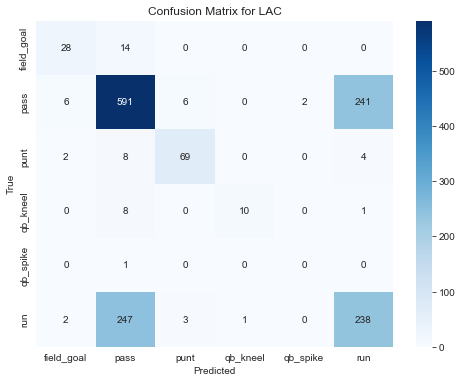

In [611]:
class_names = team_results_forest[team_name]['class_names']
team_name = 'LAC'  
print(team_results_forest[team_name]['accuracy_data'])
print(team_results_forest[team_name]['overall'])
print(team_results_forest[team_name]['report'])
plt.figure(figsize=(8, 6))
sns.heatmap(team_results[team_name]['conf_matrix'], annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'Confusion Matrix for {team_name}')

In [605]:
for i in teams:
    print(i + ' ' +team_results_forest[i]['overall'])

ARI Overall Accuracy: 88.02%

ATL Overall Accuracy: 87.67%

BAL Overall Accuracy: 87.42%

BUF Overall Accuracy: 86.35%

CAR Overall Accuracy: 86.74%

CHI Overall Accuracy: 86.90%

CIN Overall Accuracy: 86.06%

CLE Overall Accuracy: 87.13%

DAL Overall Accuracy: 86.53%

DEN Overall Accuracy: 88.70%

DET Overall Accuracy: 85.80%

GB Overall Accuracy: 86.88%

HOU Overall Accuracy: 87.00%

IND Overall Accuracy: 88.49%

JAX Overall Accuracy: 90.19%

KC Overall Accuracy: 86.40%

LA Overall Accuracy: 87.32%

LAC Overall Accuracy: 87.92%

LV Overall Accuracy: 89.59%

MIA Overall Accuracy: 87.71%

MIN Overall Accuracy: 86.95%

NE Overall Accuracy: 87.18%

NO Overall Accuracy: 87.76%

NYG Overall Accuracy: 88.66%

NYJ Overall Accuracy: 89.86%

PHI Overall Accuracy: 85.23%

PIT Overall Accuracy: 87.33%

SEA Overall Accuracy: 88.22%

SF Overall Accuracy: 87.36%

TB Overall Accuracy: 87.80%

TEN Overall Accuracy: 87.75%

WAS Overall Accuracy: 86.75%



## Part V: Cluster and Success

## BETA TESTING

In [606]:
def is_successful_play(row):
    play_type = row['play_type']
    down = row['down']
    yards_to_go = row['ydstogo']
    yards_gained = row['yards_gained']
    touchdown = row['touchdown']
    score_differential = row['score_differential']
    half_seconds_remaining = row['half_seconds_remaining']
    field_goal_result= row['field_goal_result']
    kick_distance = row['kick_distance']
    quarter = row['qtr']
    ### FIX TIME REMAINING TO SECOND IN QRT AND ADD A FIELD GOAL MADE TO 1,2,3 down and 2,4 qrt with less 60 secs left
    if down == 4:
        if touchdown == 1 or (float(yards_to_go) - float(yards_gained) <= 0) or (play_type == 'punt' and kick_distance >= 40) or (play_type == 'field_goal' and field_goal_result == 'made'):
            return "yes"
    elif down == 3:
        if touchdown == 1 or (float(yards_to_go) - float(yards_gained) <= 0) or (play_type == 'run' and score_differential > 0 and half_seconds_remaining < 300) or ((play_type == 'qb_kneel' or play_type == 'qb_spike') and half_seconds_remaining <= 120) or (play_type == 'field_goal' and field_goal_result == 'made'):
            return "yes"
    elif down == 2:
        if touchdown == 1 or (float(yards_gained)/float(yards_to_go) >= 1.0/2.0) or (play_type == 'run' and score_differential > 0 and half_seconds_remaining < 300) or ((play_type == 'qb_kneel' or play_type == 'qb_spike') and half_seconds_remaining <= 120) or (play_type == 'field_goal' and field_goal_result == 'made'):
            return "yes"
    elif down == 1:
        if touchdown == 1 or (float(yards_gained)/float(yards_to_go) >= 1.0/3.0) or (play_type == 'run' and score_differential > 0 and half_seconds_remaining < 300) or ((play_type == 'qb_kneel' or play_type == 'qb_spike')  and half_seconds_remaining <= 120) or (play_type == 'field_goal' and field_goal_result == 'made'):
            return "yes"
    return "no"

# Apply the function to each row of the dataframe and store the result in a new column
plays['success'] = plays.apply(is_successful_play, axis=1)
plays

,posteam,posteam_type,season,season_type,side_of_field,yardline_100,quarter_seconds_remaining,half_seconds_remaining,qtr,down,...,touchdown,field_goal_attempt,punt_attempt,offense_formation,offense_personnel,route,running_clock,prev_play_type,previous,success
2,TEN,home,2021-22,REG,TEN,75.0,900.0,1800.0,1,1.0,...,0.0,0.0,0.0,SINGLEBACK,"1 RB, 2 TE, 2 WR",NaN,0,kickoff,1.0,no
3,TEN,home,2021-22,REG,TEN,78.0,863.0,1763.0,1,2.0,...,0.0,0.0,0.0,SHOTGUN,"1 RB, 2 TE, 2 WR",ANGLE,1,run,7.0,no
4,TEN,home,2021-22,REG,TEN,75.0,822.0,1722.0,1,3.0,...,0.0,0.0,0.0,SHOTGUN,"1 RB, 1 TE, 3 WR",HITCH,1,pass,3.0,no
5,TEN,home,2021-22,REG,TEN,75.0,819.0,1719.0,1,4.0,...,0.0,0.0,1.0,NaN,NaN,NaN,0,pass,3.0,yes
6,ARI,away,2021-22,REG,ARI,61.0,807.0,1707.0,1,1.0,...,0.0,0.0,0.0,SHOTGUN,"1 RB, 2 TE, 2 WR",GO,0,punt,4.0,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149016,KC,home,2023-24,POST,SF,37.0,168.0,168.0,5,2.0,...,0.0,0.0,0.0,SHOTGUN,"1 RB, 1 TE, 3 WR",SCREEN,0,no_play,0.0,yes
149017,KC,home,2023-24,POST,SF,32.0,127.0,127.0,5,3.0,...,0.0,0.0,0.0,SHOTGUN,"1 RB, 2 TE, 2 WR",NaN,1,pass,3.0,yes
149018,KC,home,2023-24,POST,SF,13.0,86.0,86.0,5,1.0,...,0.0,0.0,0.0,SHOTGUN,"1 RB, 3 TE, 1 WR",NaN,1,run,7.0,no
149019,KC,home,2023-24,POST,SF,10.0,50.0,50.0,5,2.0,...,0.0,0.0,0.0,SHOTGUN,"1 RB, 1 TE, 3 WR",SCREEN,1,run,7.0,yes


In [607]:
predictors_kmeans = ['yardline_100', 
                            'down', 
                            'half_seconds_remaining', 
                            'qtr', 
                            'ydstogo',
                            'score_differential',
                            'posteam_timeouts_remaining',
                            'defteam_timeouts_remaining']

In [608]:
plays.dropna(subset=['down'], inplace=True)
plays.dropna(subset=['play_type'], inplace=True)
plays.dropna(subset=['score_differential'], inplace=True)
plays.dropna(subset=['posteam_timeouts_remaining'], inplace=True)
plays.dropna(subset=['defteam_timeouts_remaining'], inplace=True)
plays.dropna(subset=['ydstogo'], inplace=True)
plays.dropna(subset=['qtr'], inplace=True)
plays.dropna(subset=['half_seconds_remaining'], inplace=True)
plays.dropna(subset=['yardline_100'], inplace=True)

In [609]:

sse = []  # Define the list
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(plays[predictors_kmeans])
    sse.append(kmeans.inertia_)

sse  # Output the list


[8306294615.223363,
 3686677021.5798335,
 2038669251.9223793,
 1346888846.7949476,
 942361392.7107754,
 723346271.6409379,
 562549807.0409827,
 469095031.446885,
 391084219.22129875]

In [610]:
scaled_df = StandardScaler().fit_transform(plays[predictors_kmeans])

#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(700, 710):
    print(k)
    kmeans = KMeans(n_clusters=k,**kmeans_kwargs)
    kmeans.fit(plays[predictors_kmeans])
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(700,710), sse)
plt.xticks(range(700, 710))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

700
701
702


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 179, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
sse

In [ ]:
data_predictors = ['yardline_100', 
                       'half_seconds_remaining', 
                       'down',
                        'ydstogo',
                        'score_differential']

n_clusters = 768  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

data['cluster'] = kmeans.fit_predict(plays[data_predictors])

In [ ]:
data_predictors = ['yardline_100', 
                       'half_seconds_remaining', 
                       'down',
                        'ydstogo',
                        'score_differential']

n_clustersLESS = 10  # Adjust the number of clusters as needed
kmeansLESS = KMeans(n_clusters=n_clusters, random_state=42)
#kmeans.fit(data[data_predictors])

data['clusterLESS'] = kmeansLESS.fit_predict(data[data_predictors])

cluster_success_rates = {}
for cluster_id in range(768):
    cluster_data = data[data['cluster'] == cluster_id]
    success_rate = cluster_data.groupby('play_type')['success'].apply(lambda x: (x == 'yes').mean() * 100)
    cluster_success_rates[cluster_id] = dict(success_rate)
predicted_cluster = kmeans.predict([['75', '4','500', '1', '2']])
predicted_cluster[0]
cluster_success_rates[predicted_cluster[0]]